

#### import library 




In [3]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import  accuracy_score , plot_confusion_matrix ,f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import pickle
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
import xgboost
xgboost.__version__
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import joblib
from category_encoders.hashing import HashingEncoder

import warnings
warnings.filterwarnings('ignore')


#### Helper Function

In [5]:
# function train model for return predictopn of baseline model i used it with train test split only 
def baseline_model(model,X_train,y_train,X_test):
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    return model_pred


#Print the confusion matrix and classification report 
def model_information(model_pred,y_test,title):
 
    print("F1 Score Accuracy\t",f1_score(y_test, model_pred))
    print("\n")
    print(classification_report(y_test, model_pred))    
    cm = confusion_matrix(y_test, model_pred, labels=[0,1])
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot()
    plt.title(title)
    plt.show()
    pass



## Plot KDE and Hist of Each column

def kde_hist_plot(df,row,col):
  fig, ax = plt.subplots(row,col, figsize=(20, 50)) 
  fig.subplots_adjust(hspace = .2, wspace=.2, )
  ax = ax.ravel()
  for i in range(len(df.columns)):
      ax[i] = df.iloc[:,i].plot(kind='hist', ax=ax[i])
      ax[i] = df.iloc[:,i].plot(kind='kde', ax=ax[i], secondary_y=True)
      plt.title(df.columns[i])
  pass


### feature selection this function support two type of feature selection <annova, mutual information>
### if i assign the parameter annova with true that will go to annova if False that will apply mutual information
def feature_selection(X_train, Y_train, X_test, Y_test,model, n_features, anova):
  f1_acc = []
  feature = []
  for i in range(1, n_features):
    if anova:
      selecter = SelectKBest(f_classif, k = i)
    else:
      selecter = SelectKBest(mutual_info_classif, k=i)
    X_new = selecter.fit_transform(X_train, Y_train)
    X_test_new = selecter.transform(X_test)
    model.fit(X_new, Y_train)
    y_pred = model.predict(X_test_new)
    f1_acc.append(f1_score(Y_test, y_pred))
    feature.append(i)
    print("feature " + str(i) + " finished")
  return f1_acc,feature
  


#### Read that static dataset 

In [6]:
url = "/content/Static_dataset.csv"
data = pd.read_csv(url)
data.shape

(268074, 16)

#### EDA Before preprocessing

In [8]:
data.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float64(2), int64

In [10]:
data.describe()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
count,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000
mean,22.286596,6.059021,0.845420,10.410014,6.497586,2.485735,4.533577,4.788823,8.252233,4.802239,12.576714,0.753497,0.549024
std,6.001205,3.899505,4.941929,3.207725,4.499866,0.407709,2.187683,1.803256,4.415355,4.573066,4.177828,0.430975,0.497592
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000
25%,18.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000,0.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,10.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000,1.000000
max,36.000000,23.000000,32.000000,34.000000,12.000000,4.216847,7.000000,7.000000,32.000000,32.000000,33.000000,1.000000,1.000000


In [11]:
data.corr()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
FQDN_count,1.000000,0.788615,0.223162,-0.095881,0.793079,0.167806,0.748354,0.739786,0.186992,0.109444,0.588849,0.698685,0.563563
subdomain_length,0.788615,1.000000,-0.265780,-0.073809,0.944548,-0.015773,0.929076,0.923210,-0.410820,-0.431748,0.090472,0.888718,0.572053
upper,0.223162,-0.265780,1.000000,-0.555147,-0.236155,0.115458,-0.347061,-0.359428,0.847046,0.946883,0.759096,-0.299079,0.072895
lower,-0.095881,-0.073809,-0.555147,1.000000,-0.197667,0.385455,-0.068635,-0.057215,-0.074632,-0.318585,-0.072903,0.036077,-0.295599
numeric,0.793079,0.944548,-0.236155,-0.197667,1.000000,-0.084281,0.941951,0.940191,-0.395441,-0.411193,0.037743,0.801602,0.599252
entropy,0.167806,-0.015773,0.115458,0.385455,-0.084281,1.000000,-0.192317,-0.226686,0.418591,0.307460,0.526296,-0.138240,-0.119050
special,0.748354,0.929076,-0.347061,-0.068635,0.941951,-0.192317,1.000000,0.991309,-0.477689,-0.525847,-0.070203,0.890508,0.582107
labels,0.739786,0.923210,-0.359428,-0.057215,0.940191,-0.226686,0.991309,1.000000,-0.497794,-0.545609,-0.096721,0.898859,0.569414
labels_max,0.186992,-0.410820,0.847046,-0.074632,-0.395441,0.418591,-0.477689,-0.497794,1.000000,0.954819,0.856082,-0.420510,-0.096350
labels_average,0.109444,-0.431748,0.946883,-0.318585,-0.411193,0.307460,-0.525847,-0.545609,0.954819,1.000000,0.802346,-0.473714,-0.077167


In [12]:
data.skew()

FQDN_count         -1.101731
subdomain_length   -0.590480
upper               5.988737
lower               0.343449
numeric            -0.594384
entropy            -0.140156
special            -0.902972
labels             -0.903680
labels_max          3.979910
labels_average      5.087081
len                 2.634801
subdomain          -1.176397
Target Attack      -0.197046
dtype: float64

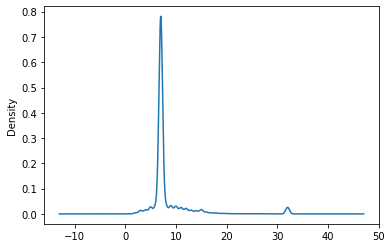

In [13]:
data['labels_max'].plot.kde()

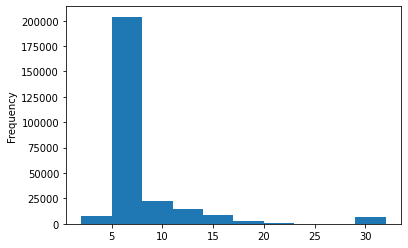

In [14]:
data['labels_max'].plot(kind='hist')

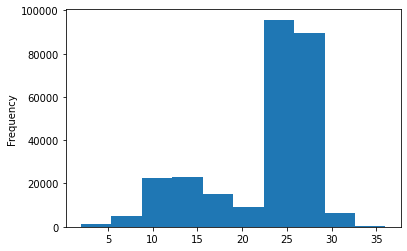

In [15]:
data['FQDN_count'].plot(kind='hist')

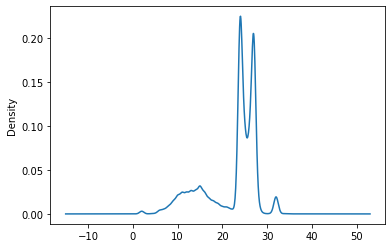

In [16]:
data['FQDN_count'].plot.kde()

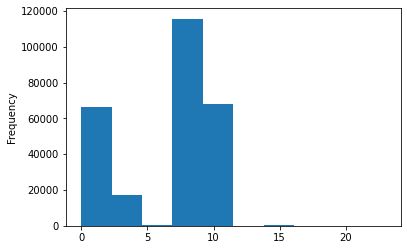

In [17]:
data['subdomain_length'].plot(kind='hist')

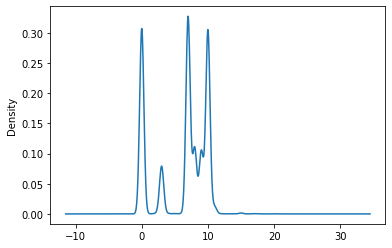

In [18]:
data['subdomain_length'].plot.kde()

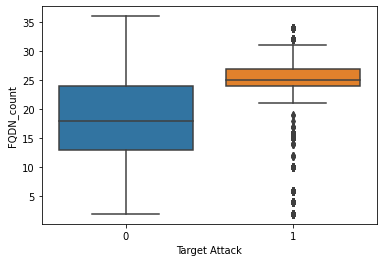

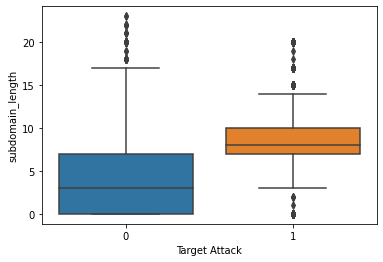

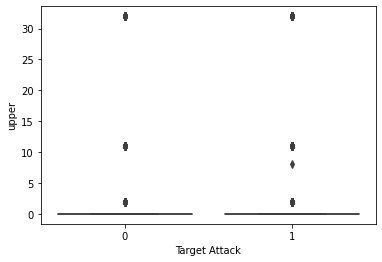

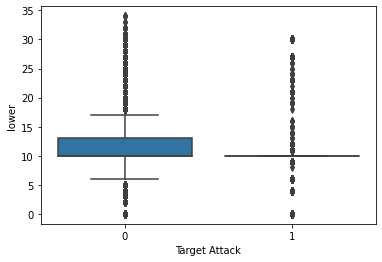

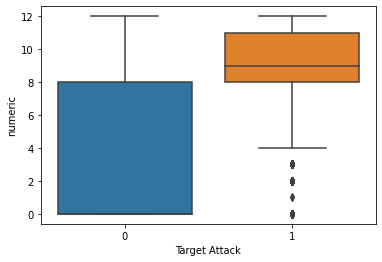

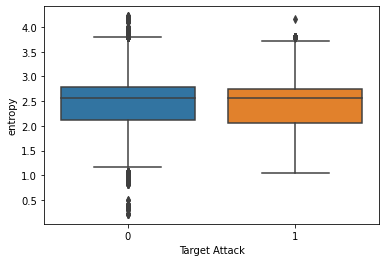

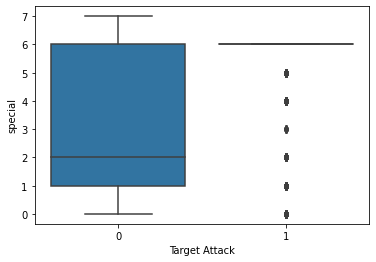

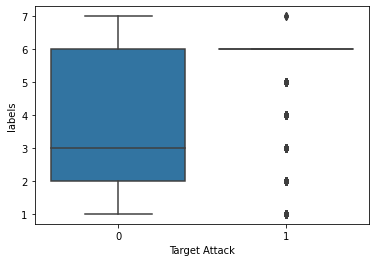

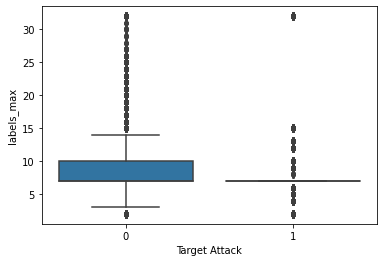

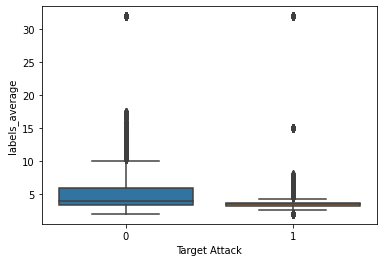

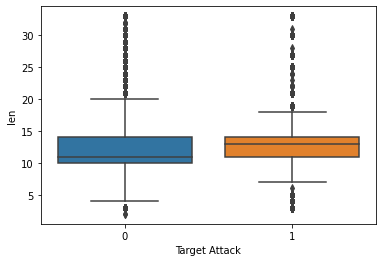

In [ ]:
for feature in data[['FQDN_count', 'subdomain_length', 'upper', 'lower',
       'numeric', 'entropy', 'special', 'labels', 'labels_max',
       'labels_average', 'len']].columns:
  sns.boxplot(x='Target Attack',y=feature,data=data)
  plt.show()

#### Preprocessing and EDA After it 

##### 1-DropNA


In [19]:
new_data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [20]:
new_data.isnull().sum()

timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        0
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

##### 2-Remove Time Stamp and got target in var y

In [22]:
X=new_data.drop(labels = ["Target Attack", "timestamp"], axis=1) 
y=new_data["Target Attack"]

##### 3-Hash encoder of categorical columns

In [27]:
## encode the two categorical data 
hash = HashingEncoder()
encoded_data = hash.fit_transform(X)


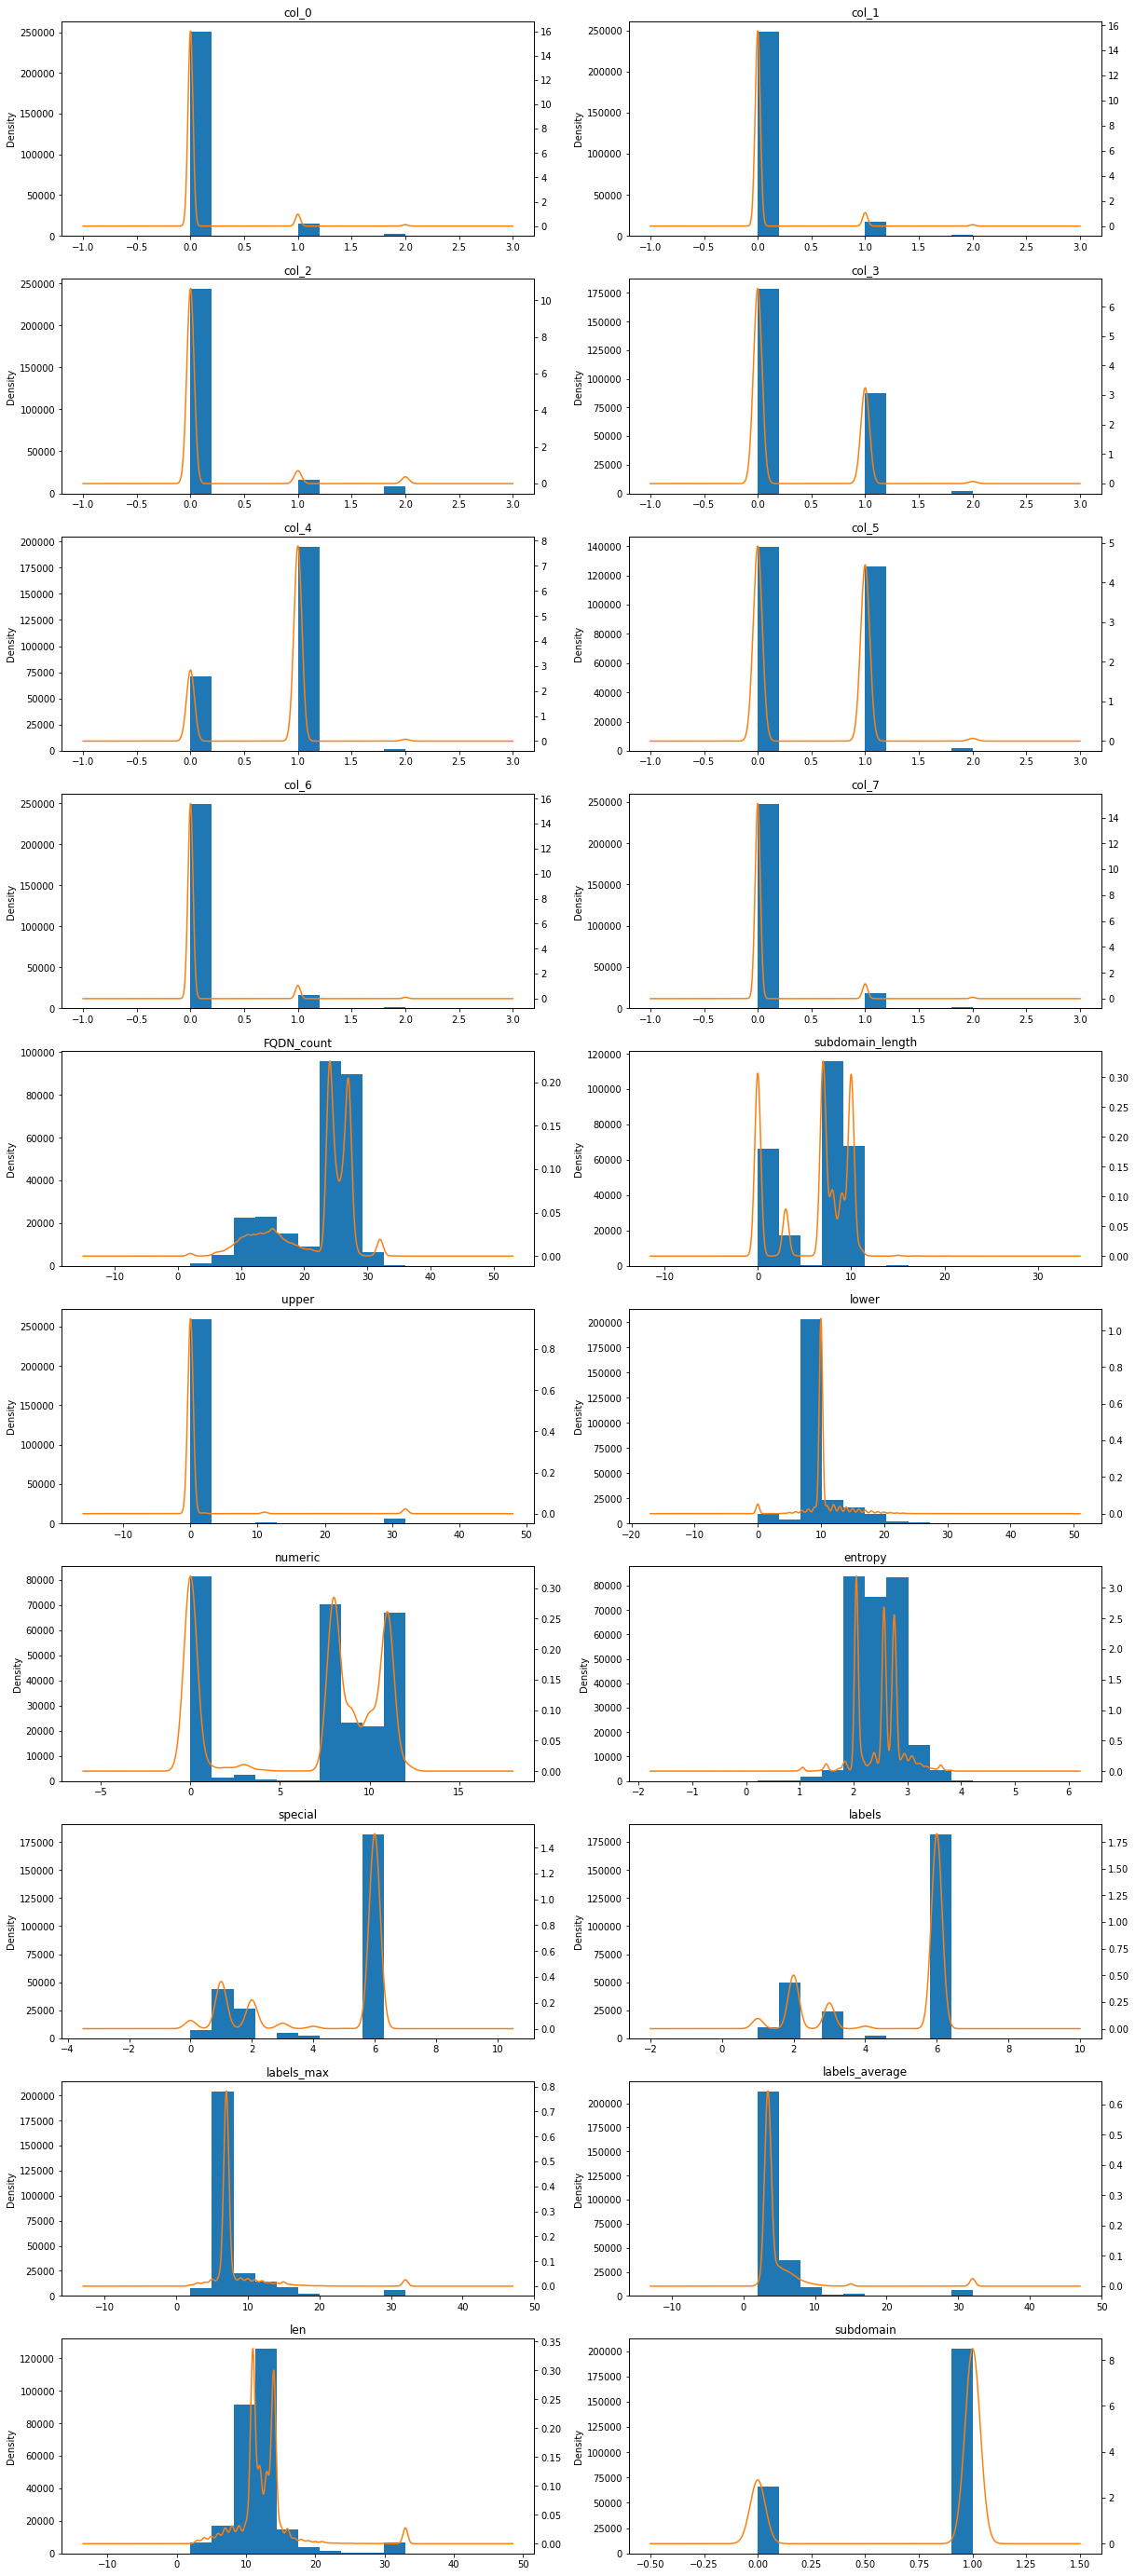

In [ ]:
##jde plot that show the density of ech columns
kde_hist_plot(encoded_data,row=10,col=2)

In [29]:
y=pd.DataFrame(y)

In [30]:
y['Target Attack'].value_counts()


1    147179
0    120895
Name: Target Attack, dtype: int64

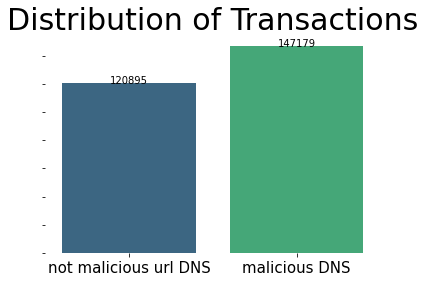

In [31]:
#using seaborns countplot to show classes 
import seaborn as sns
fig, ax = plt.subplots()
g = sns.countplot(y['Target Attack'], palette='viridis')
g.set_xticklabels(['not malicious url DNS', 'malicious DNS'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

##### 4-Split the dataset 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(encoded_data,y, test_size=0.20, random_state=42,stratify=y)
print("train data " ,X_train.shape)
print("train label " ,y_train.shape)

train data  (214459, 20)
train label  (214459, 1)


##### 5-Roubst scaller sense to outliers

In [33]:
roubst=RobustScaler()
x_tr_scaled=roubst.fit_transform(X_train)
x_tst_scaled=roubst.transform(X_test)

#### Base line Modeles


##### 1- Xgboost 

In [34]:
Model1_xgboost=XGBClassifier(random_state=42)

In [ ]:
%%time 
Model1_xgboost_pred=baseline_model(Model1_xgboost,x_tr_scaled,y_train,x_tst_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 12.9 s, sys: 5.54 ms, total: 12.9 s
Wall time: 12.8 s


recall score : 	 0.9993545318657426
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     24179
           1       0.76      1.00      0.86     29436

    accuracy                           0.83     53615
   macro avg       0.88      0.81      0.81     53615
weighted avg       0.87      0.83      0.82     53615

[[14857  9322]
 [   19 29417]]


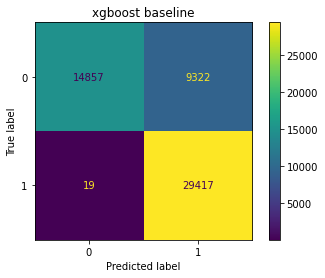

In [ ]:
model_information(Model1_xgboost_pred,y_test,"xgboost baseline")

#####2-random Forest

In [35]:
Mode4_RFC = RandomForestClassifier(random_state=42)

In [ ]:
%%time
Mode4_RFC_pred=baseline_model(Mode4_RFC,x_tr_scaled,y_train,x_tst_scaled)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 10 s, sys: 0 ns, total: 10 s
Wall time: 10 s


recall score : 	 0.9995583639081397
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     24179
           1       0.76      1.00      0.86     29436

    accuracy                           0.83     53615
   macro avg       0.88      0.81      0.81     53615
weighted avg       0.87      0.83      0.82     53615

[[14856  9323]
 [   13 29423]]


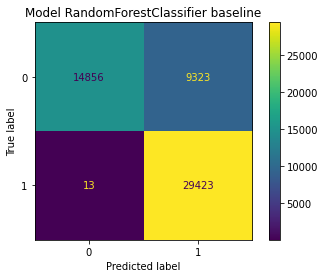

In [ ]:
model_information(Mode4_RFC_pred,y_test,"Model RandomForestClassifier baseline")

#### feature selection Annova mutual  with xgboost

###### 1) xgboost with Annova

In [ ]:
f1_acc, feature=feature_selection(x_tr_scaled, y_train, x_tst_scaled, y_test,Model1_xgboost, 20, True)

feature 1 finished
feature 2 finished
feature 3 finished
feature 4 finished
feature 5 finished
feature 6 finished
feature 7 finished
feature 8 finished
feature 9 finished
feature 10 finished
feature 11 finished
feature 12 finished
feature 13 finished
feature 14 finished
feature 15 finished
feature 16 finished
feature 17 finished
feature 18 finished
feature 19 finished


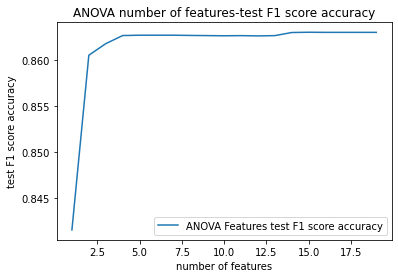

In [ ]:
plt.plot(feature, f1_acc, label = "ANOVA Features test F1 score accuracy")
plt.title("ANOVA number of features-test F1 score accuracy")
plt.xlabel("number of features")
plt.ylabel("test F1 score accuracy")
plt.legend()
plt.show()

In [ ]:
max(f1_acc)

0.8629976237275209

In [ ]:
print("number of feature based on Annova:\t",feature[np.argmax(np.array(f1_acc))])

number of feature based on Annova:	 15


In [ ]:
encoded_data.columns[selecter.get_support()]

Index(['col_0', 'col_1', 'col_4', 'col_5', 'col_6', 'col_7', 'FQDN_count',
       'subdomain_length', 'lower', 'numeric', 'special', 'labels', 'len',
       'subdomain'],
      dtype='object')

###### 2) xgboost with MUTUAL INFO

In [ ]:
f1_acc, feature=feature_selection(x_tr_scaled, y_train, x_tst_scaled, y_test,Model1_xgboost, 20, False)

feature 1 finished
feature 2 finished
feature 3 finished
feature 4 finished
feature 5 finished
feature 6 finished
feature 7 finished
feature 8 finished
feature 9 finished
feature 10 finished
feature 11 finished
feature 12 finished
feature 13 finished
feature 14 finished
feature 15 finished
feature 16 finished
feature 17 finished
feature 18 finished
feature 19 finished


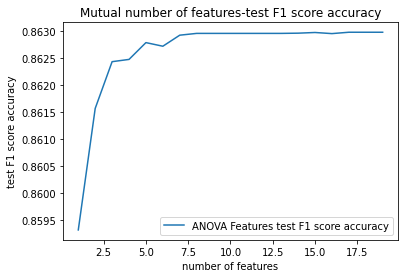

In [ ]:
plt.plot(feature, f1_acc, label = "Mutual Features test F1 score accuracy")
plt.title("Mutual number of features-test F1 score accuracy")
plt.xlabel("number of features")
plt.ylabel("test F1 score accuracy")
plt.legend()
plt.show()

In [ ]:
max(f1_acc)

0.8629849651631829

In [ ]:
print("number of feature based on Mutual:\t",feature[np.argmax(np.array(f1_acc))])

number of feature based on Mutual:	 17


#### feature selection Annova mutual  with Random Forest


###### 1) RandomForest with Annova

In [36]:
Mode4_RFC = RandomForestClassifier(random_state=42)

In [20]:
f1_acc, feature=feature_selection(x_tr_scaled, y_train, x_tst_scaled, y_test,Mode4_RFC, 20, True)

feature 1 finished
feature 2 finished
feature 3 finished
feature 4 finished
feature 5 finished
feature 6 finished
feature 7 finished
feature 8 finished
feature 9 finished
feature 10 finished
feature 11 finished
feature 12 finished
feature 13 finished
feature 14 finished
feature 15 finished
feature 16 finished
feature 17 finished
feature 18 finished
feature 19 finished


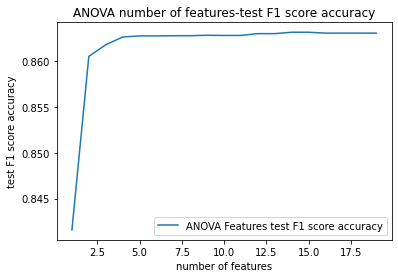

In [ ]:
plt.plot(feature, f1_acc, label = "ANOVA Features test F1 score accuracy")
plt.title("ANOVA number of features-test F1 score accuracy")
plt.xlabel("number of features")
plt.ylabel("test F1 score accuracy")
plt.legend()
plt.show()

In [21]:
max(f1_acc)

0.8631683923386032

In [22]:
print("number of feature based on Annova:\t",feature[np.argmax(np.array(f1_acc))])

number of feature based on Annova:	 14


###### 2) Random Forest with MUTUAL INFO

In [ ]:
f1_acc, feature=feature_selection(x_tr_scaled, y_train, x_tst_scaled, y_test,Mode4_RFC, 20, False)

feature 1 finished
feature 2 finished
feature 3 finished
feature 4 finished
feature 5 finished
feature 6 finished
feature 7 finished
feature 8 finished
feature 9 finished
feature 10 finished
feature 11 finished
feature 12 finished
feature 13 finished
feature 14 finished
feature 15 finished
feature 16 finished
feature 17 finished
feature 18 finished
feature 19 finished


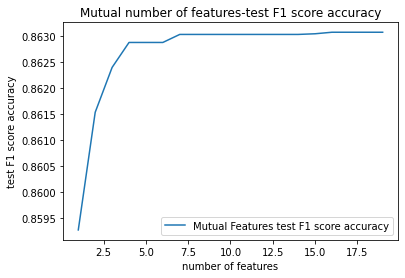

In [ ]:
plt.plot(feature, f1_acc, label = "Mutual Features test F1 score accuracy")
plt.title("Mutual number of features-test F1 score accuracy")
plt.xlabel("number of features")
plt.ylabel("test F1 score accuracy")
plt.legend()
plt.show()

In [ ]:
max(f1_acc)

0.8630723651403596

In [ ]:
print("number of feature based on Mutual:\t",feature[np.argmax(np.array(f1_acc))])

number of feature based on Mutual:	 16


#### Tunned RandomForest


In [37]:
Mode4_RFC = RandomForestClassifier(random_state=42)
selecter = SelectKBest(f_classif, k = 14)
X_new_annova_rf = selecter.fit_transform(x_tr_scaled, y_train)
X_test_new_annova_rf = selecter.transform(x_tst_scaled)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(Mode4_RFC, X_new_annova_rf, y_train, cv=10,scoring='f1')
print("f1score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


f1score: 0.86 (+/- 0.00)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
rfc = RandomForestClassifier( random_state=42)

param_dist = {
    'max_depth': [2, 4, 8, 12],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators':[10,100,200,250]
}

scorer = make_scorer(f1_score)


gs = GridSearchCV(estimator=rfc, param_grid=param_dist, n_jobs = -1 ,
                        cv=5, scoring=scorer)


gs.fit(X_new_annova_rf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 12],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [10, 100, 200, 250]},
             scoring=make_scorer(f1_score))

In [ ]:
gs.best_params_

{'max_depth': 12, 'min_samples_split': 4, 'n_estimators': 200}

In [54]:
##tunned random forest
rfc_tunned = RandomForestClassifier( random_state=42,max_depth=12, min_samples_split= 4, n_estimators= 200)


In [55]:
%%time
scores = cross_val_score(rfc_tunned, X_new_annova_rf, y_train, cv=10,scoring='f1')
print("F1 score : %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))  


F1 score : 0.86 (+/- 0.00)
CPU times: user 2min 33s, sys: 1.29 s, total: 2min 35s
Wall time: 2min 34s


#### Tunned XGBOOST


In [ ]:
### randomForest with best  15 feature from Annova to see the f1 score accuracy
selecter_xgb = SelectKBest(f_classif, k = 15)
X_new_annova_xgb = selecter_xgb.fit_transform(x_tr_scaled, y_train)
X_test_new_annova_xgb = selecter_xgb.transform(x_tst_scaled)

scores_xgb = cross_val_score(Model1_xgboost, X_new_annova_xgb, y_train, cv=10,scoring='f1')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))



Accuracy: 0.86 (+/- 0.00)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
xgbb=XGBClassifier(random_state=42)

param_dist = {
    'eta': [.3,.6],
    'max_depth': [15, 20],
    'min_child_weight':[6,8],
    'subsample':[.7,.9],
    'colsample_bytree':[.7,.9],

}

from sklearn.model_selection import RandomizedSearchCV
# Build a random search using param_dist, rfr, and scorer
random_search = RandomizedSearchCV(estimator=xgbb,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   scoring=f1_score
                                  )


random_search.fit(X_new_annova_xgb, y_train)

In [ ]:
random_search.best_params_

{'subsample': 0.9,
 'min_child_weight': 8,
 'max_depth': 20,
 'eta': 0.6,
 'colsample_bytree': 0.9}

In [ ]:
###Tunning the xgboost with best parameter 
xgboost_tunned = XGBClassifier(random_state=42,subsample= 0.9,
 min_child_weight=8,
 max_depth=20,
 eta= 0.6,colsample_bytree=0.9,
 n_estimators=200,
 )


In [ ]:
%%time
scores_xgb_tunned = cross_val_score(xgboost_tunned, X_new_annova_xgb, y_train, cv=10,scoring='f1')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb_tunned.mean(), scores_xgb_tunned.std()))


Accuracy: 0.86 (+/- 0.00)
CPU times: user 10min 18s, sys: 1.11 s, total: 10min 20s
Wall time: 10min 18s


#### ROC Curve


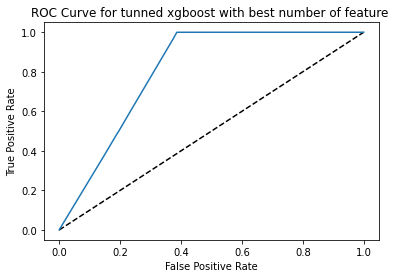

In [ ]:
##roc_curve for tunned xgboost with best number of feature 
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
xgboost_tunned.fit(X_new_annova_xgb,y_train)
y_pred_prob = xgboost_tunned.predict_proba(X_test_new_annova_xgb)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for tunned xgboost with best number of feature ')
plt.show()

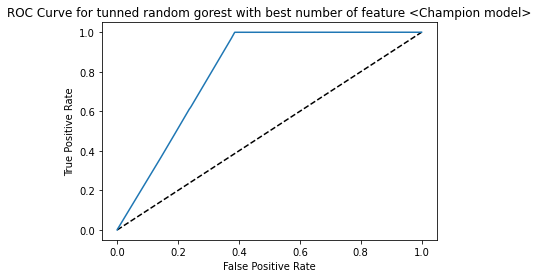

In [ ]:
##roc_curve for champion model tunned random Forest classifier with best feature 
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
rfc_tunned.fit(X_new_annova_rf,y_train)
y_pred_prob = rfc_tunned.predict_proba(X_test_new_annova_rf)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for tunned random gorest with best number of feature <Champion model>')
plt.show()

The champion model is randomforest beacause it has less number of feature compared to xgboost and it takes less tim than xgboost  

#### pickles for Champion model random forest tunned  With all data and best number of feature from annova 

In [28]:
##save hash encoder as pickle file  that i will use it in dynamic model 
pickle.dump(hash, open('hashed_pickl_a.pkl', 'wb'))

In [39]:
rfc_tunned_ = RandomForestClassifier( random_state=42,max_depth=12, min_samples_split= 4, n_estimators= 200)
selecter2 = SelectKBest(f_classif, k = 14)
X_new_annova_rf_ = selecter2.fit_transform(x_tr_scaled, y_train)
X_test_new_annova_rf_ = selecter2.transform(x_tst_scaled)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc_tunned_, X_new_annova_rf_, y_train, cv=10,scoring='f1')
print("f1score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1score: 0.86 (+/- 0.00)


In [40]:
encoded_data.columns[selecter2.get_support()]

Index(['col_0', 'col_1', 'col_4', 'col_5', 'col_6', 'col_7', 'FQDN_count',
       'subdomain_length', 'lower', 'numeric', 'special', 'labels', 'len',
       'subdomain'],
      dtype='object')

In [41]:
updated_data=encoded_data[['col_0', 'col_1', 'col_4', 'col_5', 'col_6', 'col_7', 'FQDN_count',
       'subdomain_length', 'lower', 'numeric', 'special', 'labels', 'len',
       'subdomain']]

In [42]:
roubst_all=RobustScaler()
robst_all_data=roubst_all.fit_transform(updated_data)

In [43]:
##imo
pickle.dump(roubst_all, open('roubst_scaller_alldata_ver2.pkl', 'wb'))


In [44]:
rfc_tunned_.fit(robst_all_data,y)

RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=200,
                       random_state=42)

In [45]:
pickle.dump(rfc_tunned_, open('Final_rf_model2.pkl', 'wb'))

In [46]:
prediction_rf=rfc_tunned_.predict(X_test_new_annova_rf_)

F1 Score Accuracy	 0.8631477054397724
Recall Score Accuracy	 0.9996602799293383


              precision    recall  f1-score   support

           0       1.00      0.61      0.76     24179
           1       0.76      1.00      0.86     29436

    accuracy                           0.83     53615
   macro avg       0.88      0.81      0.81     53615
weighted avg       0.87      0.83      0.82     53615

[[14858  9321]
 [   10 29426]]


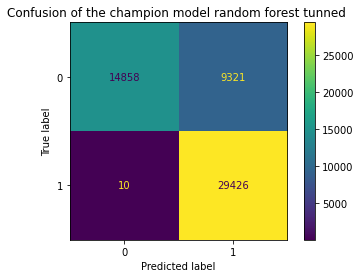

In [48]:
print("F1 Score Accuracy\t",f1_score(y_test, prediction_rf))
print("Recall Score Accuracy\t",recall_score(y_test, prediction_rf))

print("\n")
print(classification_report(y_test, prediction_rf))    
cm = confusion_matrix(y_test, prediction_rf, labels=[0,1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
plt.title("Confusion of the champion model random forest tunned ")
plt.show()
